## Initial Exploration of Data

##### Business Problem - 

A real estate company plans to purchase properties to rent out short-term as part of their business model specifically within New York City. The real estate company has already concluded that two bedroom properties are the most profitable; however, the company doesn't know which zip codes are the best to invest in.

My job is to build a data product and provide conclusions to help them understand which zip codes would generate the most profit on short term rentals within New York City.

##### The publicly available data used for the analysis - 

1. Zillow dataset (cost data): Provides selling cost for 2 bedroom properties in each zipcode for various cities. The cost        information is available from April 1996 to June 2017.

2. Airbnb dataset (revenue data): Information about property listings in New York including location, number of bedrooms, reviews, price, availability, property description, etc. AirBnB is the medium through which the real estate company plans to lease out their investment property.

##### Assumptions - 
1. The investor will pay for the property in cash (i.e. no mortgage/interest rate will need to be accounted for).

2. The time value of money discount rate is 0% (i.e. $1 today is worth the same 100 years from now).

3. All properties and all square feet within each locale can be assumed to be homogeneous (i.e. a 1000 square foot property in a    locale such as Bronx or Manhattan generates twice the revenue and costs twice as much as any other 500 square foot property      within that same locale.)

4. Occupancy rate of 75% throughout the year for Airbnb properties.

5. The company will put properties on rent every day throughout the year.

6. We assume that 40 percent of bookings are single day bookings that last less than a week, 40 percent are weekly bookings and    20 percent of bookings are made for a month. This assumption is cursory and done for the sake of this exercise. [Guessed from    basic internet research]

In [2]:
### Importing Libraries

import pandas as pd
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime
from sklearn.metrics import mean_squared_error
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from sklearn.impute import KNNImputer
import plotly

%matplotlib inline

warnings.filterwarnings('ignore')
pd.set_option('max_columns', None)

#### Importing Data 

In [3]:
### Reading Listings 

listings = pd.read_csv("listings.csv")
listings.shape

(48895, 106)

In [4]:
### Readings Zillow 

sellingdata = pd.read_csv('Zip_Zhvi_2bedroom.csv')
sellingdata.shape

(8946, 262)

In [5]:
listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2539,https://www.airbnb.com/rooms/2539,20190708031610,2019-07-09,Clean & quiet apt home by the park,Renovated apt home in elevator building.,"Spacious, renovated, and clean apt home, one b...",Renovated apt home in elevator building. Spaci...,none,Close to Prospect Park and Historic Ditmas Park,If this room is unavailable on your desired da...,Very close to F and G trains and Express bus i...,NaN,NaN,-The security and comfort of all our guests is...,NaN,NaN,https://a0.muscache.com/im/pictures/3949d073-a...,NaN,2787,https://www.airbnb.com/users/show/2787,John,2008-09-07,"New York, New York, United States",Educated professional living in Brooklyn. I l...,within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/8674565a-7...,https://a0.muscache.com/im/pictures/8674565a-7...,Gravesend,6.0,6.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Brooklyn , NY, United States",Brooklyn,Kensington,Brooklyn,Brooklyn,NY,11218,New York,"Brooklyn , NY",US,United States,40.64749,-73.97237,f,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Wheelchair acces...",NaN,$149.00,$299.00,$999.00,$100.00,$25.00,1,$35.00,1,730,1,1,730,730,1.0,730.0,3 weeks ago,t,30,60,90,365,2019-07-09,9,2,2015-12-04,2018-10-19,98.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,f,f,moderate,f,f,6,0,5,1,0.21
1,2595,https://www.airbnb.com/rooms/2595,20190708031610,2019-07-09,Skylit Midtown Castle,"Find your romantic getaway to this beautiful, ...","- Spacious (500+ft²), immaculate and nicely fu...","Find your romantic getaway to this beautiful, ...",none,Centrally located in the heart of Manhattan ju...,NaN,Apartment is located on 37th Street between 5t...,"Guests have full access to the kitchen, bathro...",I am a Sound Therapy Practitioner and Kundalin...,"Make yourself at home, respect the space and t...",NaN,NaN,https://a0.muscache.com/im/pictures/f0813a11-4...,NaN,2845,https://www.airbnb.com/users/show/2845,Jennifer,2008-09-09,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,within a few hours,87%,NaN,f,https://a0.muscache.com/im/users/2845/profile_...,https://a0.muscache.com/im/users/2845/profile_...,Midtown,5.0,5.0,"['email', 'phone', 'reviews', 'kba', 'work_ema...",t,t,"New York, NY, United States",M

In [6]:
sellingdata.head(2)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
0,61639,10025,New York,NY,New York,New York,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,798600.0,798800.0,801500.0,804600.0,814900.0,828300.0,835700.0,849300.0,858100.0,854000.0,834800.0,821700.0,830300.0,853700.0,868300.0,875200.0,882200.0,892400.0,905000.0,924000.0,934400.0,932100.0,927500.0,923600.0,907900.0,890900.0,883400.0,896100.0,923900.0,952900.0,964600.0,972500.0,973800.0,973400.0,966500.0,966800.0,967100.0,974800.0,976800.0,976100.0,973700.0,974500.0,973200.0,966400.0,950400.0,933300.0,920900.0,909400.0,891400.0,873300.0,858800.0,850200.0,842800.0,834000.0,828800.0,821400.0,813900.0,813300.0,821500.0,831700.0,845100.0,854500.0,858900.0,859200.0,863500.0,876000.0,886100.0,890000.0,894200.0,901800.0,909500.0,913300.0,907400.0,900000.0,897700.0,896300.0,892300.0,890400.0,888600.0,891700.0,899500.0,904400.0,908200.0,914000.0,915100.0,912300.0,914000.0,921100.0,923300.0,917300.0,915000.0,922800.0,929100.0,937700.0,955700.0,974200.0,995500.0,1019500.0,1035100.0,1054900.0,1079900,1092600,1103500,1118800,1139300,1154600,1144100,1120300,1125500,1136000,1135100,1130000,1138200,1153700,1174800,1185400,1188400,1189700,1193700,1199900,1201400,1202600,1214200,1235200,1258000,1287700,1307200,1313900,1317100,1327400,1338800.0,1350400.0,1356600.0,1358500.0,1364000,1373300,1382600,1374400,1364100,1366300,1354800.0,1327500,1317300,1333700,1352100,1390000,1431000
1,84654,60657,Chicago,IL,Chicago,Cook,2,167700.0,166400.0,166700.0,167200.0,166900.0,166900.0,168000.0,170100.0,171700.0,173000.0,17460

#### Initial Preprocessing

Listings data has been scraped on 2019-07-09 and 2019-07-08. Selling Price data is available uptill 2017-06. We need to forecast the selling price for each region in New York (since the listings data is only for New York) till 2019. 
Selling data is available from 1996. For forecasting the prices, data from last five years, i.e. data from 2012.
There are 25 zipcodes within New York city that are listed in the selling data.



#### Forecasting selling price for 2019

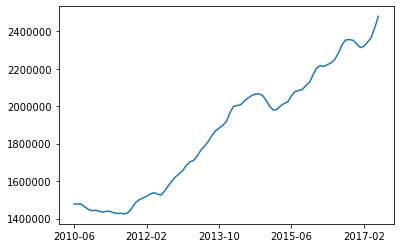

In [7]:
sellingdataNY = sellingdata[sellingdata['City']=='New York'].reset_index().drop("index",axis = 1)
cols = ([1,6] + list(range(177,sellingdataNY.shape[1])))
sellingdataNY = sellingdataNY.iloc[:,cols]
sellingdataNY.iloc[3,2:].plot()

The time series data for each zipcode is not stationary. Autocorrelation plot for zipcode 10011 shows that there is a 
positive correlation untill lag of 30 with a significant correlation till lag of 20. 

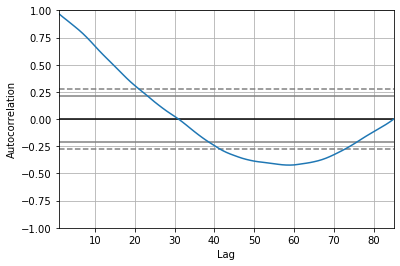

In [8]:
series10011 = sellingdataNY.iloc[3,2:]
series10011.index = series10011.reset_index()['index'].apply(lambda x: str(datetime.strptime(x,"%Y-%m")))
autocorrelation_plot(series10011)

In [9]:
X = series10011.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

predicted=1971852.459002, expected=1982900.000000
predicted=1996166.585004, expected=2001600.000000
predicted=2019659.435069, expected=2014700.000000
predicted=2022550.829543, expected=2023500.000000
predicted=2033046.873745, expected=2055300.000000
predicted=2092398.306526, expected=2078300.000000
predicted=2085732.136784, expected=2083600.000000
predicted=2089653.658636, expected=2088800.000000
predicted=2095568.109463, expected=2110600.000000
predicted=2136418.306027, expected=2127500.000000
predicted=2135120.986226, expected=2168900.000000
predicted=2214600.107389, expected=2204700.000000
predicted=2223414.010706, expected=2216100.000000
predicted=2223435.087532, expected=2212500.000000
predicted=2209854.849669, expected=2222600.000000
predicted=2239923.597743, expected=2231900.000000
predicted=2237468.497832, expected=2250800.000000
predicted=2272341.745468, expected=2285200.000000
predicted=2314521.524958, expected=2329100.000000
predicted=2365156.285908, expected=2354000.000000


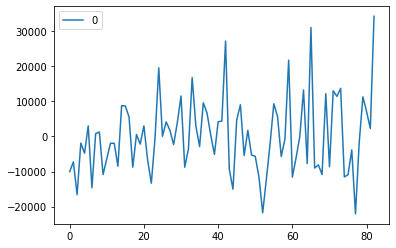

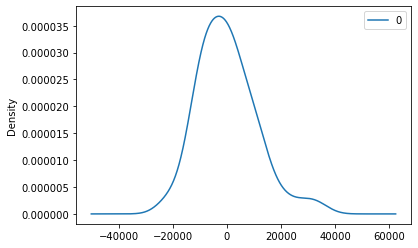

                  0
count     83.000000
mean      14.090909
std    10850.386606
min   -22078.060400
25%    -7919.922954
50%    -1817.638292
75%     5626.364048
max    34264.539475


In [10]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

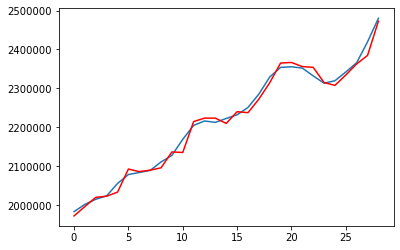

In [11]:
# plot predicted and actual values
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

Arima takes values in an array and not in a 1D or 2D model. 
This creates a arima model for each zipcode and forecasts till 2019-07

In [9]:
forecast_daterange = []
for t in range(1,26):
    forecast_daterange.append(str(datetime.date(datetime.strptime('2017-06-01 00:00:00', "%Y-%m-%d %H:%M:%S")) + relativedelta(months=+t)))

forecast_df = pd.DataFrame()
#forecast_df.index = forecast_daterange

for region in range(sellingdataNY.shape[0]):
    print("Region forecasting for ",sellingdataNY.iloc[region,0])
    seriesregion = sellingdataNY.iloc[region,2:]
    seriesregion.index = seriesregion.reset_index()['index'].apply(lambda x: str(datetime.strptime(x,"%Y-%m")))
    ## autocorrelation_plot(seriesregion)
    ## fit model
    model = ARIMA(seriesregion.values, order=(1,1,0))
    model_fit = model.fit(disp=0)
    ## print(model_fit.summary())
    forecast_df[sellingdataNY.iloc[region,0]] = pd.Series(model_fit.forecast(steps = 25)[0])
    ## plot residual errors
    ## residuals = pd.DataFrame(model_fit.resid)
    ## residuals.plot()
    ## plt.show()
    ## residuals.plot(kind='kde')
    ## plt.show()
    ## print(residuals.describe())   
forecast_df.index = forecast_daterange    

Region forecasting for  10025
Region forecasting for  10023
Region forecasting for  10128
Region forecasting for  10011
Region forecasting for  10003
Region forecasting for  11201
Region forecasting for  11234
Region forecasting for  10314
Region forecasting for  11215
Region forecasting for  10028
Region forecasting for  10021
Region forecasting for  10014
Region forecasting for  10036
Region forecasting for  11434
Region forecasting for  10306
Region forecasting for  10312
Region forecasting for  10022
Region forecasting for  11217
Region forecasting for  10013
Region forecasting for  11231
Region forecasting for  10304
Region forecasting for  10305
Region forecasting for  10309
Region forecasting for  10308
Region forecasting for  10303


#### Cleaning airbnb data

In [10]:
## There are 106 columns in the airbnb data. Out of those, I am keeping columns related to price data and reviews data

columns_to_keep = ['id','name','host_since','neighbourhood','neighbourhood_group_cleansed','city','state','zipcode','latitude',
'longitude','property_type','accommodates','bathrooms','bedrooms','beds','square_feet','price','weekly_price','monthly_price', 
'security_deposit', 'cleaning_fee','guests_included', 'extra_people', 'minimum_nights','maximum_nights','number_of_reviews',
'review_scores_rating','review_scores_accuracy','review_scores_cleanliness', 'review_scores_location','review_scores_value']
listings = listings[columns_to_keep]

In [11]:
## Cleaning zipcode
listings['zipcode'] = listings['zipcode'].apply(lambda x: int(str(x).replace('\n','-').replace('nan','0').replace('.0','').split('-')[0]))

## Filtering New York state
listings = listings[listings['state'].isin(['NY','Ny','ny','New York'])].reset_index().drop('index',axis = 1)

## Filtering Bedrooms. After filtering 41473 rows remain
#listings['beds'].value_counts()
#listings.groupby(['bedrooms','beds'])['id'].count().unstack('beds')
listings = listings[listings['bedrooms'].isin([2])].reset_index().drop('index',axis = 1)

In [12]:
## Cleaning datatype for prices

listings['price'] = listings['price'].apply(lambda x: float(str(x).replace('$','').replace(',','')))
listings['weekly_price'] = listings['weekly_price'].apply(lambda x: float(str(x).replace('$','').replace(',','')))
listings['monthly_price'] = listings['monthly_price'].apply(lambda x: float(str(x).replace('$','').replace(',','')))
listings['security_deposit'] = listings['security_deposit'].apply(lambda x: float(str(x).replace('$','').replace(',','')))
listings['cleaning_fee'] = listings['cleaning_fee'].apply(lambda x: float(str(x).replace('$','').replace(',','')))
listings['extra_people'] = listings['extra_people'].apply(lambda x: float(str(x).replace('$','').replace(',','')))

#### Merge listings data to sellingdataNY

In [13]:
listings = sellingdataNY[['RegionName','SizeRank']].merge(listings,left_on = 'RegionName',right_on = 'zipcode')
listings = listings.merge(forecast_df.T['2019-07-01'],left_on = 'zipcode',right_index = True)
listings.shape

(1564, 34)

#### Handling missing Values

There no missing values for price which is the most important variable here. There is hardly any data for square foot, which 
should be an important variable as the selling price of real estate depends on it. Security deposit and cleaning fee has more than 70% data, so listings with missing values can be imputed. 

Missing values for square_feet, monthly_price, weekly_price and other columns can be imputed using KNN imputer

In [14]:
## Percentge of missing values in the listings data
listings.count()/1564*100

RegionName                      100.000000
SizeRank                        100.000000
id                              100.000000
name                            100.000000
host_since                       99.936061
neighbourhood                   100.000000
neighbourhood_group_cleansed    100.000000
city                             99.808184
state                           100.000000
zipcode                         100.000000
latitude                        100.000000
longitude                       100.000000
property_type                   100.000000
accommodates                    100.000000
bathrooms                        99.808184
bedrooms                        100.000000
beds                            100.000000
square_feet                       1.726343
price                           100.000000
weekly_price                     13.682864
monthly_price                    10.677749
security_deposit                 73.209719
cleaning_fee                     86.508951
guests_incl

In [17]:
imputer = KNNImputer(n_neighbors=5)
listings_imputed = pd.DataFrame(imputer.fit_transform(listings[['zipcode','latitude',
'longitude','accommodates','bathrooms','bedrooms','beds','square_feet','price','weekly_price','monthly_price', 
'security_deposit', 'cleaning_fee','guests_included', 'extra_people', 'minimum_nights','maximum_nights','number_of_reviews',
'review_scores_rating','review_scores_accuracy','review_scores_cleanliness', 'review_scores_location','review_scores_value']]))

listings_imputed.columns = ['zipcode','latitude',
'longitude','accommodates','bathrooms','bedrooms','beds','square_feet','price','weekly_price','monthly_price', 
'security_deposit', 'cleaning_fee','guests_included', 'extra_people', 'minimum_nights','maximum_nights','number_of_reviews',
'review_scores_rating','review_scores_accuracy','review_scores_cleanliness', 'review_scores_location','review_scores_value']

listings = listings[['id','name','host_since','neighbourhood','neighbourhood_group_cleansed','city','state','property_type']].merge(listings_imputed, left_index = True, right_index = True)

listings = listings.merge(forecast_df.T['2019-07-01'],left_on = 'zipcode',right_index = True)

#### Aggregating Data

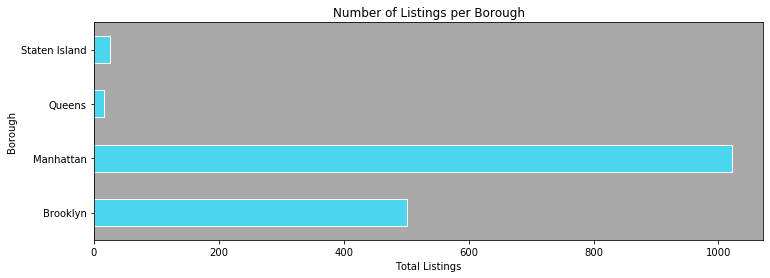

In [19]:
### Number of listings per neighbourhood

ax = listings.groupby('neighbourhood_group_cleansed')['id'].count().plot(
    kind = 'barh', figsize = (12,4), title = 'Number of Listings per Borough',color="#4bd5ee",edgecolor = 'white')
plt.xlabel('Total Listings')
plt.ylabel('Borough')
ax.set_facecolor("darkgray")

Manhattan has the highest number of listings, followed with Brooklyn. There 

In [20]:
zipcode_listings = pd.DataFrame({'count': listings.groupby('zipcode')['id'].count(),
              'price':listings.groupby('zipcode')['price'].mean(),
              'cost':listings.groupby('zipcode')['2019-07-01'].mean()}).merge(
    listings[['zipcode','neighbourhood_group_cleansed']].drop_duplicates(),left_index = True, right_on = 'zipcode')

zipcode_listings

,count,price,cost,zipcode,neighbourhood_group_cleansed
373,136,318.713235,2.446725e+06,10003.0,Manhattan
267,106,368.726415,2.957563e+06,10011.0,Manhattan
1344,105,397.847619,3.692501e+06,10013.0,Manhattan
1399,105,397.847619,3.692501e+06,10013.0,Brooklyn
894,90,344.833333,2.712394e+06,10014.0,Manhattan
867,27,260.407407,2.112065e+06,10021.0,Manhattan
1149,71,348.887324,2.303297e+06,10022.0,Manhattan
124,78,288.243590,2.546256e+06,10023.0,Manhattan
0,124,319.540323,1.709679e+06,10025.0,Manhattan
794,73,273.794521,2.582350e+06,10028.0,Manhattan


In [22]:
## Number of listings per zip code. 
#fig, ax = plt.subplots(figsize=(6,4))
#plt.subplots(figsize=(20,15))
#g = sns.catplot(x="zipcode", y="count",data=zipcode_listings, hue="neighbourhood_group_cleansed", 
#                kind="bar", palette = "deep")
#g.set_axis_labels("Zipcode","Total Listings")
#sns.mpl.rc("figure", figsize=(9,4))#.despine(left = True)
#sns.set_context("poster")
#plt.figure(figsize=(20,20))
#sns.set_style("darkgrid", {"axes.facecolor": ".9"})
#sns.set_context("paper")
#sns.axes_style()

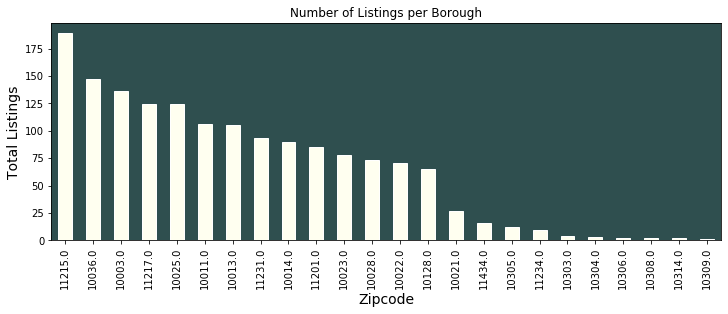

In [23]:
ax = listings.groupby('zipcode')['id'].count().sort_values(ascending = False).plot(
    kind = 'bar', figsize = (12,4), title = 'Number of Listings per Borough',color="ivory",edgecolor = 'white')
plt.xlabel('Zipcode',fontsize = 14)
plt.ylabel('Total Listings',fontsize = 14)
ax.set_facecolor("darkslategray")

In [136]:
zipcode_listings.sort_values('count',ascending = False)

,count,price,cost,zipcode,neighbourhood_group_cleansed
605,189,181.608466,1.224307e+06,11215.0,Brooklyn
984,147,338.591837,1.823798e+06,10036.0,Manhattan
373,136,318.713235,2.446725e+06,10003.0,Manhattan
0,124,319.540323,1.709679e+06,10025.0,Manhattan
1220,124,234.443548,1.545782e+06,11217.0,Brooklyn
267,106,368.726415,2.957563e+06,10011.0,Manhattan
1344,105,397.847619,3.692501e+06,10013.0,Manhattan
1399,105,397.847619,3.692501e+06,10013.0,Brooklyn
1449,93,207.978495,1.323522e+06,11231.0,Brooklyn
894,90,344.833333,2.712394e+06,10014.0,Manhattan


The mean for total listings per zipcode is 66 with std deviation at 55. Since the coefficint of variation is very high, I will remove zipcodes with very few listings as they might skew the analysis. Out of the 24 zipcodes, 16 remain after filtering, 5 from Brooklyn, 11 from Manhattan and 1 from Queens

In [24]:
listings_filtered = listings[listings['zipcode'].isin(zipcode_listings[zipcode_listings['count']>15]['zipcode'])]

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


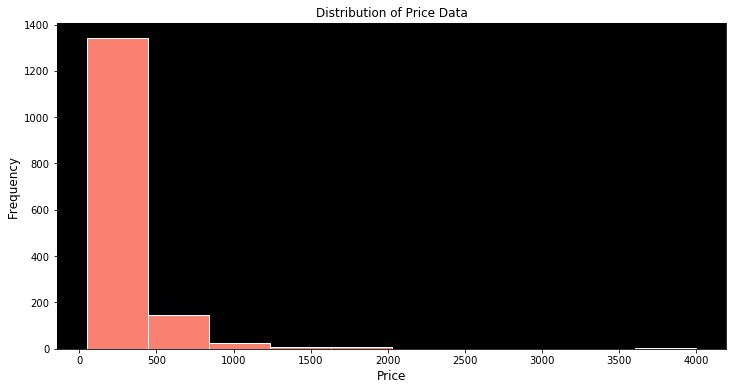

In [26]:
## Distribution of price data

hfont = {'fontname':'Helvetica'}
ax = listings_filtered['price'].plot(kind = 'hist', title = 'Distribution of Price Data',edgecolor = 'white', color = 'salmon',figsize = (12,6))
plt.xlabel('Price',fontsize = 12)##, **hfont)
plt.ylabel('Frequency',fontsize = 12)#**hfont)
ax.set_facecolor("black")

The distribution of price(per night) shows that there a few outliers in the data. Slicing them and looking at the description shows that they might be legit listings and removing them from the aggregation might skew the results. The listings are are loated majorly in 10025, 10128, 10011, 10003

In [144]:
listings_filtered[listings_filtered['price']>1500]

,id,name,host_since,neighbourhood,neighbourhood_group_cleansed,city,state,property_type,zipcode,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_location,review_scores_value,2019-07-01
3,174966,Luxury 2Bed/2.5Bath Central Park View,2011-07-18,Upper West Side,Manhattan,New York,NY,Condominium,10025.0,40.77350,-73.98697,9.0,2.5,2.0,3.0,1050.0,2000.0,3490.0,15000.0,1224.0,138.0,4.0,0.0,30.0,1125.0,30.0,99.0,10.0,10.0,9.0,9.0,1.709679e+06
6,664047,Lux 2Bed/2.5Bath Central Park Views,2011-07-18,Upper West Side,Manhattan,New York,NY,Condominium,10025.0,40.77516,-73.98573,8.0,2.5,2.0,3.0,1050.0,2000.0,3490.0,15000.0,1224.0,138.0,4.0,0.0,30.0,1125.0,59.0,97.0,10.0,10.0,10.0,9.0,1.709679e+06
23,5616298,Lux 2Bed/2.5Bath Central Park View!,2011-07-18,Upper West Side,Manhattan,New York,NY,Condominium,10025.0,40.77470,-73.98708,7.0,2.5,2.0,2.0,851.6,2000.0,2830.0,15000.0,0.0,0.0,6.0,0.0,30.0,1125.0,9.0,98.0,10.0,10.0,10.0,10.0,1.709679e+06
24,5649623,Lux 2Bed/2Bath Central Park Views!,2011-07-18,Manhattan,Manhattan,New York,NY,Condominium,10025.0,40.77306,-73.98637,8.0,2.0,2.0,3.0,1050.0,2000.0,4390.0,16500.0,1324.0,168.0,4.0,0.0,30.0,1125.0,9.0,98.0,10.0,10.0,9.0,9.0,1.709679e+06
264,36189257,2BR Near Museum Mile! Upper East Side!,2019-06-29,Upper East Side,Manhattan,New York,NY,Apartment,10128.0,40.78132,-73.95262,4.0,1.0,2.0,2.0,990.0,1999.0,4230.0,15700.0,200.0,135.0,1.0,0.0,30.0,1125.0,0.0,98.4,10.0,10.0,9.6,9.4,2.310927e+06
277,2276383,Penthouse with Private Rooftop for Events/Shoots,2014-01-25,Greenwich Village,Manhattan,New York,NY,Apartment,10011.0,40.73350,-73.99834,6.0,2.5,2.0,2.0,1070.0,2500.0,12500.0,40000.0,5000.0,300.0,1.0,0.0,1.0,1125.0,0.0,99.2,10.0,10.0,10.0,10.0,2.957563e+06
388,2281142,Prime NYC Location for Super Bowl,2011-11-20,East Village,Manhattan,New York,NY,Apartment,10003.0,40.73323,-73.98859,4.0,1.0,2.0,4.0,990.0,3750.0,6048.8,20300.0,1220.0,175.0,1.0,0.0,1.0,1125.0,0.0,98.4,10.0,10.0,9.6,9.4,2.446725e+06
868,2284454,MANHATTAN SUPERBOWL ACCOMODATION,2014-01-26,Upper East Side,Manhattan,New York,NY,Apartment,10021.0,40.76904,-73.95435,8.0,2.0,2.0,4.0,990.0,1600.0,6850.0,15700.0,1264.0,163.0,1.0,0.0,1.0,1125.0,0.0,98.4,10.0,10.0,9.6,9.4,2.112065e+06
977,33718046,Prime Location!Cozy 2BR in West Village!,2019-04-04,West Village,Manhattan,New York,NY,Apartment,10014.0,40.73037,-74.00497,4.0,1.0,2.0,2.0,990.0,1799.0,6850.0,20300.0,1264.0,163.0,1.0,0.0,2.0,1124.0,0.0,98.4,10.0,10.0,9.6,9.4,2.712394e+06
1175,15857259,5 Star Luxury 2 BR Suite Heart of Manhattan,2015-01-22,Midtown,Manhattan,New York,NY,Serviced apartment,10022.0,40.76110,-73.97412,6.0,2.0,2.0,2.0,990.0,2000.0,2899.0,15500.0,500.0,147.0,1.0,0.0,2.0,90.0,3.0,100.0,10.0,10.0,10.0,10.0,2.303297e+06


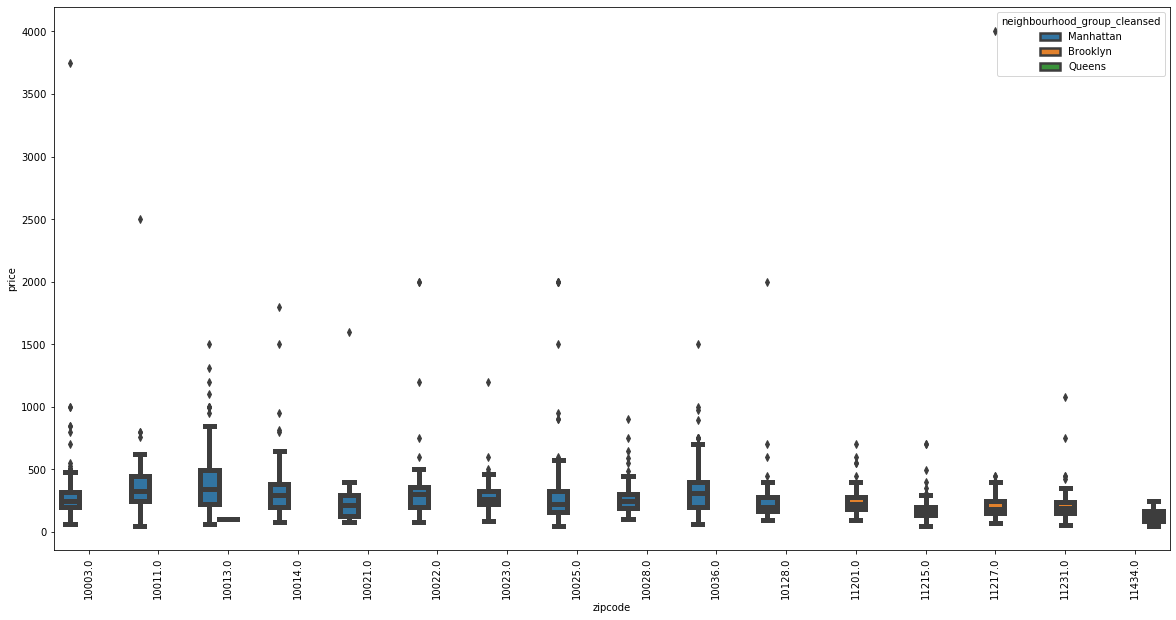

In [27]:
fig, ax = plt.subplots(figsize=(20,10))
#plt.subplots(figsize=(20,15))
chart = sns.boxplot(x=listings_filtered["zipcode"], y=listings_filtered["price"], linewidth=5, hue = listings_filtered['neighbourhood_group_cleansed'])
tickx = chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

In [28]:
listings_filtered['zipcode'] = listings_filtered['zipcode'].apply(lambda x: str(x).replace('.0',''))

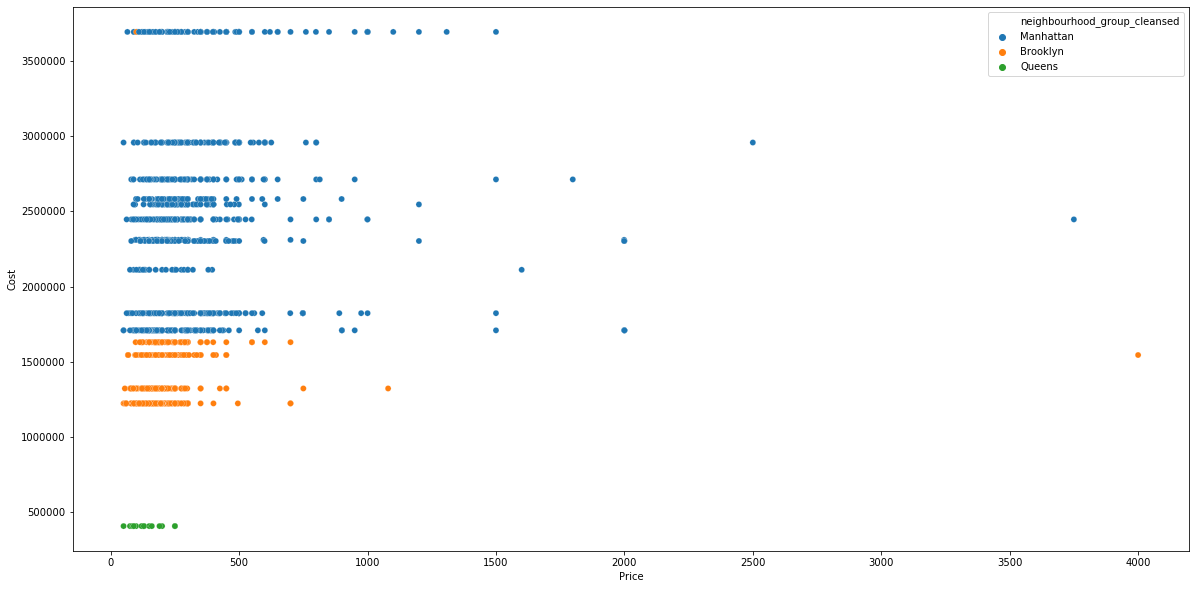

In [54]:
fig, ax = plt.subplots(figsize=(20,10))
chart = sns.scatterplot(x="price", y="2019-07-01",hue="neighbourhood_group_cleansed", linewidth=0.2,
        data=listings_filtered,legend = "full")
#                        palette=["windows blue", "amber", "greyish", "faded green", "dusty purple",
#        "bluish","baby pink","chocolate","sky", "dark red","dark teal","violet","brown", "green", "faded red", "indigo",])
var = chart.set(xlabel = "Price",ylabel = "Cost")

In [30]:
listings.columns

Index(['id', 'name', 'host_since', 'neighbourhood',
       'neighbourhood_group_cleansed', 'city', 'state', 'property_type',
       'zipcode', 'latitude', 'longitude', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'square_feet', 'price', 'weekly_price',
       'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included',
       'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_location',
       'review_scores_value', '2019-07-01'],
      dtype='object')

In [42]:
p_daily = .40 # probability that booking is done for a day

p_weekly = .40 # probability that booking is done for a week

p_monthly = .2 # probability that booking is done for a month

occupancy_rate = .75

In [32]:
zipcode_summary = listings.groupby('zipcode')[['square_feet', 'price', 'weekly_price','monthly_price', 'security_deposit', 'cleaning_fee','2019-07-01']].mean()

In [48]:
zipcode_summary['yearly_revenue'] = occupancy_rate * 365 * ((zipcode_summary['price'] * p_daily) + (zipcode_summary['weekly_price'] * p_weekly/7) + (zipcode_summary['monthly_price']) * p_monthly/30)
zipcode_summary['yearly_revenue_cleaning'] = zipcode_summary['yearly_revenue'] - (occupancy_rate * 100 * zipcode_summary['cleaning_fee'])

In [51]:
zipcode_summary['breakeven_year'] = zipcode_summary['2019-07-01']/zipcode_summary['yearly_revenue_cleaning']

In [52]:
zipcode_summary.head(2)

,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,2019-07-01,yearly_revenue,yearly_revenue_cleaning,breakeven_year
zipcode,,,,,,,,,,
10003.0,977.217647,318.713235,1793.383824,5749.851471,492.882353,102.442647,2.446725e+06,73446.225152,65763.026623,37.205170
10011.0,993.773585,368.726415,2123.703774,6520.100000,537.820755,125.375472,2.957563e+06,85495.519697,76092.359319,38.868066


In [53]:
zipcode_summary

,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,2019-07-01,yearly_revenue,yearly_revenue_cleaning,breakeven_year
zipcode,,,,,,,,,,
10003.0,977.217647,318.713235,1793.383824,5749.851471,492.882353,102.442647,2.446725e+06,73446.225152,65763.026623,37.205170
10011.0,993.773585,368.726415,2123.703774,6520.100000,537.820755,125.375472,2.957563e+06,85495.519697,76092.359319,38.868066
10013.0,993.920000,397.847619,2178.874286,6527.072381,547.087619,120.045714,3.692501e+06,89560.040565,80556.611993,45.837345
10014.0,983.802222,344.833333,1961.980000,6256.748889,552.900000,113.511111,2.712394e+06,79868.789579,71355.456246,38.012420
10021.0,1019.629630,260.407407,1583.711111,5124.866667,578.888889,95.874074,2.112065e+06,62641.259444,55450.703889,38.089051
10022.0,997.487324,348.887324,1799.847887,6016.926761,773.422535,154.230986,2.303297e+06,77338.816690,65771.492746,35.019687
10023.0,987.435897,288.243590,1742.992308,5855.966667,568.538462,135.894872,2.546256e+06,69515.191914,59323.076529,42.921843
10025.0,984.380645,319.540323,1709.998387,5514.058065,388.870968,107.300000,1.709679e+06,71802.081774,63754.581774,26.816568
10028.0,973.331507,273.794521,1745.649315,5677.084932,466.421918,137.753425,2.582350e+06,67648.122857,57316.616008,45.054126


In [ ]:
{'axes.facecolor': 'white',
 'axes.edgecolor': '.8',
 'axes.grid': True,
 'axes.axisbelow': True,
 'axes.labelcolor': '.15',
 'figure.facecolor': 'white',
 'grid.color': '.8',
 'grid.linestyle': '-',
 'text.color': '.15',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'image.cmap': 'rocket',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'patch.force_edgecolor': True,
 'xtick.bottom': False,
 'xtick.top': False,
 'ytick.left': False,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True}